In [1]:
import numpy as np
import pandas as pd
import sys, codecs
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import math
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from gensim.models.phrases import Phrases,Phraser
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
import ast
import os    
import glob
import datetime
import umap
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from textblob import TextBlob
import matplotlib.pyplot as plt

In [2]:
# 连接input csv
citys=['L']
# citys=['M']
firstflag=0
for city in citys:
    path=r'UBDC/sale_2020/'+city+'/'
    filepath=path+'*dim*.csv'
    #     print(filepath)
    for csvname in glob.glob(filepath):
        print(csvname)
        if firstflag==0:
            df_input=pd.read_csv(csvname)
            firstflag=1
        else:
            df_input=df_input.append(pd.read_csv(csvname),ignore_index=True)
df_input=df_input.fillna(0)
df_input_store=df_input[['polarity','subjectivity','lon','lat']]
df_input.drop(['lon','lat','Unnamed: 0','bed_flag','polarity','subjectivity'],axis=1,inplace=True)
list_county=[w for w in df_input.columns if w[0:6]=='county']
df_input.drop(list_county,axis=1,inplace=True)
df_input=df_input.astype(int)
df_input=pd.concat([df_input,df_input_store],axis=1)
df_input.drop(df_input[df_input['price_last']==0].index,axis=0,inplace=True)
df_input.reset_index(drop=True,inplace=True)

UBDC/sale_2020/L/00001_diminput.csv
UBDC/sale_2020/L/00000_diminput.csv
UBDC/sale_2020/L/00004_diminput.csv
UBDC/sale_2020/L/00002_diminput.csv
UBDC/sale_2020/L/00003_diminput.csv


In [35]:
df_input

,end_date,price_last,num_bed_last,num_floors_max,num_bath_max,num_reception_max,glaze,radiator,liverpool,tiled,...,lad20nm_Knowsley,lad20nm_Liverpool,lad20nm_Sefton,property_type_Office,property_type_Retail premises,property_type_Terraced bungalow,polarity,subjectivity,lon,lat
0,338,135000,3,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0.106471,0.511176,-2.824951,53.398790
1,43,185000,2,0,2,2,0,0,1,0,...,0,1,0,0,0,0,0.201476,0.468403,-2.985536,53.398680
2,31,79950,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0.204940,0.494405,-2.980047,53.421013
3,154,199950,3,0,1,2,1,1,0,1,...,0,1,0,0,0,0,0.094936,0.307628,-2.953689,53.377773
4,115,142000,1,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0.396526,0.502090,-2.985380,53.414380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23643,485,220000,2,0,1,2,0,0,0,0,...,0,1,0,0,0,0,0.196689,0.458056,-2.921890,53.399600
23644,23,120000,3,0,1,2,0,0,1,0,...,0,1,0,0,0,0,0.579167,0.555556,-2.925207,53.427240
23645,141,176995,3,2,2,2,0,0,1,0,...,0,1,0,0,0,0,0.263117,0.492324,-2.854253,53.340443
23646,38,195000,4,0,3,2,0,0,0,0,...,1,0,0,0,0,0,0.229660,0.538367,-2.854919,53.430000


In [47]:
gdf = gpd.read_file('shapefile/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.geojson')
G=gdf[gdf['TCITY15NM']=='Liverpool']
G=G.to_crs("epsg:27700")
gdf_input=gpd.GeoDataFrame(df_input[['lon','lat']],geometry=gpd.points_from_xy(df_input.lon, df_input.lat, crs='epsg:4326'))
gdf_input=gdf_input.to_crs("epsg:27700")
gdf_input=gpd.sjoin(gdf_input,G[['geometry']], how="inner", op='intersects').reset_index()
london_index=gdf_input['index']
df_input=df_input.iloc[london_index]
num0col=pd.DataFrame(df_input.sum()) #remove sum=0 columns
col=num0col[num0col[0]==0].index
df_input.drop(col,axis=1,inplace=True)
df_input.reset_index(drop=True,inplace=True)

In [172]:
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:487]
train_x, test_x, train_y, test_y = train_test_split(df_input.drop(['price_last'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x[['lon','lat']]
test_x_g=test_x[['lon','lat']]
train_x.drop(['lon','lat'],axis=1,inplace=True)
test_x.drop(['lon','lat'],axis=1,inplace=True)
train_x.reset_index(inplace=True,drop=True)
test_x.reset_index(inplace=True,drop=True)
train_y.reset_index(inplace=True,drop=True)
test_y.reset_index(inplace=True,drop=True)

lasso

In [173]:
%%time
lasso_model = Lasso( normalize=True)
lasso_model.fit(X=train_x, y=train_y)

CPU times: user 29 s, sys: 1min 18s, total: 1min 47s
Wall time: 6.9 s


Lasso(normalize=True)

In [174]:
lasso_model.score(X=train_x, y=train_y)

0.653123073575517

In [175]:
lasso_model.score(X=test_x, y=test_y)

0.6570251433814036

In [40]:
%%time
from sklearn.linear_model import LassoCV
alphas = 10**np.linspace(- 3, 3, 100) 
lasso_cv = LassoCV(alphas = alphas, normalize= True, cv = 20, max_iter= 500000).fit(train_x, train_y)

CPU times: user 5min 29s, sys: 12min 27s, total: 17min 56s
Wall time: 2min 52s


In [41]:
best_alpha

0.8111308307896873

In [189]:
# 0.5336699231206312
best_alpha=lasso_cv.alpha_
lasso_model = Lasso(max_iter=10e7, normalize=True, alpha = best_alpha)
lasso_model.fit(X=train_x, y=train_y)
print(lasso_model.score(train_x, train_y))
print(lasso_model.score(test_x, test_y))

0.6520882812562958
0.656546898727913


In [177]:
pd.set_option('display.max_rows', 200)
df_coef_lasso = pd.DataFrame({"var": train_x.columns.values, "coef":lasso_model.coef_})
useless_var=df_coef_lasso[df_coef_lasso.coef==0]['var'].values
useless_var

array(['radiator', 'liverpool', 'floor', 'city', 'heating', 'road',
       'vendor', 'reception', 'marketing', 'viewing', 'day', 'reveal',
       'porch', 'solely_vendor', 'light', 'mid', 'fall',
       'minimum_acceptable', 'acceptable', 'reserve_pricesguide', 'space',
       'garage', 'fit', 'centre', 'complete', 'mid_terraced', 'piece',
       'fitment_tasteful', 'maintain', 'ormskirk', 'sell',
       'usual_provisional', 'complementary', 'bathroom', 'school',
       'attractive', 'inspection', 'assist_consumer', 'abode', 'overlook',
       'prospective', 'definition_guide', 'reserve_pricethe',
       'university', 'stone_throw', 'stage_adjust', 'beautifully',
       'immaculate', 'bed', 'demand', 'carpeted', 'generous',
       'register_info', 'contemporary', 'huyton',
       'prices_liverpoolliverpool', 'buyers', 'detach', 'separate',
       'measurement', 'investment_purposes', 'professional', 'friend',
       'stylish', 'approval_require', 'accommodation', 'mount',
       'accur

continue connect data

In [3]:
df_input=df_input.rename(columns={'end_date':'date_since_2019','num_bed_last':'num_bed',
# 'num_floors_max':'num_floors',
 'num_bath_max':'num_bath',
 'num_reception_max':'num_reception',
'polarity':"sentiment_polarity",
 'subjectivity':'sentiment_subjectivity'})
useless_var=['radiator', 'liverpool', 'floor', 'city', 'heating', 'road',
       'vendor', 'reception', 'marketing', 'viewing', 'day', 'reveal',
       'porch', 'solely_vendor', 'light', 'mid', 'fall',
       'minimum_acceptable', 'acceptable', 'reserve_pricesguide', 'space',
       'garage', 'fit', 'centre', 'complete', 'mid_terraced', 'piece',
       'fitment_tasteful', 'maintain', 'ormskirk', 'sell',
       'usual_provisional', 'complementary', 'bathroom', 'school',
       'attractive', 'inspection', 'assist_consumer', 'abode', 'overlook',
       'prospective', 'definition_guide', 'reserve_pricethe',
       'university', 'stone_throw', 'stage_adjust', 'beautifully',
       'immaculate', 'bed', 'demand', 'carpeted', 'generous',
       'register_info', 'contemporary', 'huyton',
       'prices_liverpoolliverpool', 'buyers', 'detach', 'separate',
       'measurement', 'investment_purposes', 'professional', 'friend',
       'stylish', 'approval_require', 'accommodation', 'mount',
       'accurate_reliable', 'pack', 'merseyside', 'precise_advise',
       'management', 'purchase', 'greet', 'cameron_mackenzie', 'live',
       'summaryjones_chapman', 'activity', 'expert', 'valuation',
       'designate', 'personal', 'southport', 'laid', 'floorbedroom',
       'sitting', 'basin', 'loft', 'heat', 'ensure_happy', 'stand_crowd',
       'acumen_estates', 'epc_grade', 'aerial_shot',
       'employment_prospect', 'blind', 'plentiful', 'freestanding',
       'quiet_cul', 'abundance', 'website', 'car', 'fast', 'rainhill',
       'oven', 'ability_efficiency', 'continue', 'guarantee', 'accuracy',
       'protection_misleading', 'true', 'salon', 'invest_booming',
       'international_significance', 'network', 'deposit_requireda',
       'town', 'sold', 'restaurant', 'whiston_hospital', 'landingwith',
       'wet', 'convenient', 'approach', 'upper', 'extractor',
       'capital_growth', 'financial_breakdown', 'roomdouble', 'south',
       'property_type_Country house', 'property_type_Lodge',
       'property_type_Parking/garage',
       'property_type_Semi-detached house', 'lad20nm_St. Helens',
       'property_type_Office', 'property_type_Retail premises',
       'property_type_Terraced bungalow']
df_input.drop(useless_var,axis=1,inplace=True)
notext_index=df_input[df_input.iloc[:,5:486].T.sum()==0].index #去掉单词列全为零的行
df_input.drop(notext_index,axis=0,inplace=True)

In [49]:
df_input.to_csv('L_dim1.csv',index=False) #去掉lasso的无用变量
df_input[['lon','lat']].to_csv('L_dim_lonlat1.csv',index=False)

# test set

In [202]:
# notext+sen
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last','sentiment_polarity','sentiment_subjectivity']+text_col, axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [200]:
# nosen
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last','sentiment_polarity','sentiment_subjectivity'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [195]:
# notext
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last']+text_col, axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [188]:
%%time
lasso_model = Lasso( normalize=True)
lasso_model.fit(X=train_x_notext, y=train_y_notext)
print(lasso_model.score(X=train_x_notext, y=train_y_notext),'\n',lasso_model.score(X=test_x_notext, y=test_y_notext))

0.5436611286122084 
 0.5578857034302338
CPU times: user 142 ms, sys: 780 ms, total: 923 ms
Wall time: 103 ms


regression tree

In [5]:
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x, test_x, train_y, test_y = train_test_split(df_input.drop(['price_last'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x[['lon','lat']]
test_x_g=test_x[['lon','lat']]
train_x.drop(['lon','lat'],axis=1,inplace=True)
test_x.drop(['lon','lat'],axis=1,inplace=True)
train_x.reset_index(inplace=True,drop=True)
test_x.reset_index(inplace=True,drop=True)
train_y.reset_index(inplace=True,drop=True)
test_y.reset_index(inplace=True,drop=True)

In [192]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=8)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(train_x, train_y)
print("R2 on the training data:")
print(reg_tree.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x, y=test_y))
from sklearn.metrics import mean_squared_error
print("RMSE on the training data:")
print(mean_squared_error(train_y, reg_tree.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, reg_tree.predict(test_x), squared=False))

R2 on the training data:
0.9997041137177765
R2 on the testing data:
0.7314504507198457
RMSE on the training data:
2486.464913950919
RMSE on the testing data:
75436.03051189799


In [35]:
# notext
# train set and test set 
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x, test_x, train_y, test_y = train_test_split(df_input.drop(['price_last']+text_col, axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x[['lon','lat']]
test_x_g=test_x[['lon','lat']]
train_x.drop(['lon','lat'],axis=1,inplace=True)
test_x.drop(['lon','lat'],axis=1,inplace=True)
train_x.reset_index(inplace=True,drop=True)
test_x.reset_index(inplace=True,drop=True)
train_y.reset_index(inplace=True,drop=True)
test_y.reset_index(inplace=True,drop=True)

In [196]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=8)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(train_x_notext, train_y_notext)
print("R2 on the training data:")
print(reg_tree.score(X=train_x_notext, y=train_y_notext))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x_notext, y=test_y_notext))
from sklearn.metrics import mean_squared_error
print("RMSE on the training data:")
print(mean_squared_error(train_y_notext, reg_tree.predict(train_x_notext), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y_notext, reg_tree.predict(test_x_notext), squared=False))

R2 on the training data:
0.9996198238415982
R2 on the testing data:
0.685092414984795
RMSE on the training data:
2818.4631357370085
RMSE on the testing data:
81687.98327906021


random forest

In [6]:
%%time
from sklearn.ensemble import RandomForestRegressor
randomState_rf = 8
rf = RandomForestRegressor(n_estimators=10, random_state=randomState_rf,n_jobs=-1)
rf.fit(train_x,train_y)
print("R2 on the training data:")
print(rf.score(train_x,train_y))
print("R2 on the testing data:")
print(rf.score(test_x,test_y))

R2 on the training data:
0.958831287639411
R2 on the testing data:
0.8156942468011246
CPU times: user 18.7 s, sys: 0 ns, total: 18.7 s
Wall time: 2.08 s


In [203]:
%%time
# 没文本变量的

from sklearn.ensemble import RandomForestRegressor
randomState_rf = 8
rf = RandomForestRegressor(n_estimators=10, random_state=randomState_rf,n_jobs=-1)
rf.fit(train_x_notext,train_y_notext)
print("R2 on the training data:")
print(rf.score(train_x_notext,train_y_notext))
print("R2 on the testing data:")
print(rf.score(test_x_notext,test_y_notext))

R2 on the training data:
0.9116113478781169
R2 on the testing data:
0.725705176361654
CPU times: user 638 ms, sys: 0 ns, total: 638 ms
Wall time: 122 ms


                              Importance
Feature                                 
num_bed                         0.540708
property_type_Detached house    0.138329
num_reception                   0.125127
property_type_Terraced house    0.100878
num_bath                        0.058534
...                                  ...
decorative                     -0.000446
al_fresco                      -0.000503
change                         -0.000861
formal                         -0.001194
driveway                       -0.001778

[402 rows x 1 columns]


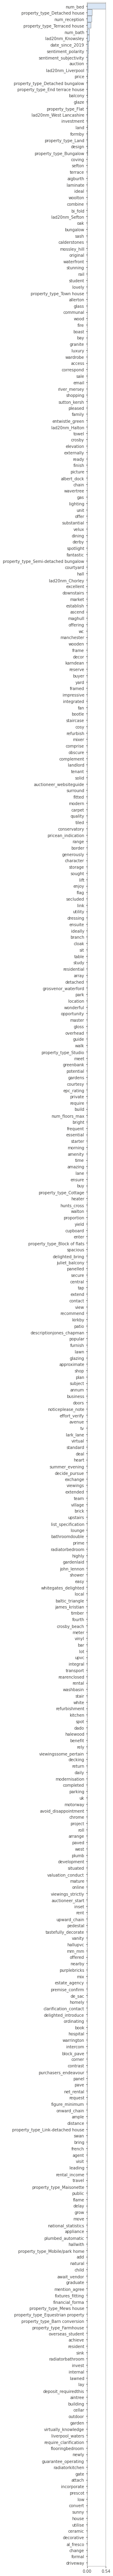

In [8]:
import rfpimp
imp = rfpimp.importances(rf, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [9]:
imp[0:50].to_csv('l_sig50.csv')

In [62]:
%%time
# cross va
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
X_train_val = pd.concat([train_x,test_x])
y_train_val = pd.concat([train_y,test_y])
# values of n_estimators
parameters = {'n_estimators':[10,20,30,40,50,70,100,200]}
rf = RandomForestRegressor(n_jobs=-1)

# cv=5 by default, which means 5-fold cross-validation
clf = model_selection.GridSearchCV(rf, parameters)

clf.fit(X_train_val, y_train_val)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'n_estimators': 10}
The best score is: 
0.7599479140229596
CPU times: user 28.7 s, sys: 5.5 s, total: 34.2 s
Wall time: 4min 47s


dim forgwr

In [149]:
gwr_x=df_input.drop(['price_last','lon','lat'],axis=1)
gwr_y=df_input[['price_last']]
gwr_xy=df_input[['lon','lat']]

In [150]:
gwr_x

,date_since_2019,num_bed,num_bath,num_reception,glaze,radiator,liverpool,tiled,laminate,floor,...,property_type_Semi-detached house,property_type_Studio,property_type_Terraced house,property_type_Town house,lad20nm_Knowsley,lad20nm_Sefton,property_type_Retail premises,property_type_Terraced bungalow,sentiment_polarity,sentiment_subjectivity
0,338,3,1,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0.106471,0.511176
1,43,2,2,2,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0.201476,0.468403
2,31,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.204940,0.494405
3,154,3,1,2,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0.094936,0.307628
4,115,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.396526,0.502090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23643,485,2,1,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.196689,0.458056
23644,23,3,1,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.579167,0.555556
23645,141,3,2,2,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0.263117,0.492324
23646,38,4,3,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.229660,0.538367


In [151]:
df_toUMAP=gwr_x.drop(['date_since_2019',
 'num_bed',
#  'num_floors',
 'num_bath',
 'num_reception','sentiment_polarity',
 'sentiment_subjectivity'],axis=1)
#  ,'luxury' ,'ideal', 'rare'
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.01,
    n_components=5,
    random_state=8)

arr_UMAP=reducer.fit_transform(df_toUMAP)

df_x_10=pd.DataFrame(arr_UMAP,columns= ['E'+str(x) for x in np.arange(0,5)])
gwr_x=pd.concat([gwr_x[['date_since_2019',
 'num_bed',
#  'num_floors',
 'num_bath',
 'num_reception','sentiment_polarity',
 'sentiment_subjectivity']],df_x_10],axis=1) 

gwr

In [152]:
# gwr input
# train_x=pd.read_csv('train_x.csv')[0:30000]
# train_y=pd.read_csv('train_y.csv')[0:30000]
# train_x_g=pd.read_csv('train_x_g.csv')[0:30000]
train_cor=list(zip(gwr_xy['lon'],gwr_xy['lat']))
# test_cor=list(zip(test_x['lon'],test_x['lat']))
train_x_g1=gwr_x.values
# test_x_g=test_x[gwr_var].values
train_y_g1 =gwr_y.values.reshape((-1,1))
# test_y_g =test_y.values.reshape((-1,1))
# train_cor1=train_cor[0:5000]
# train_y_g1=train_y_g[0:5000]
# train_x_g1=train_x_g[0:5000]

In [153]:
gwr_x

,date_since_2019,num_bed,num_bath,num_reception,sentiment_polarity,sentiment_subjectivity,E0,E1,E2,E3,E4
0,338,3,1,1,0.106471,0.511176,3.134925,2.646661,10.035479,0.702000,0.745119
1,43,2,2,2,0.201476,0.468403,2.039418,9.260751,1.052382,3.203110,8.422384
2,31,2,0,0,0.204940,0.494405,3.610826,2.391159,11.014763,0.995796,0.826836
3,154,3,1,2,0.094936,0.307628,4.691611,1.332340,10.025871,2.038339,2.212733
4,115,1,1,1,0.396526,0.502090,7.886811,-5.377297,12.366737,-2.912855,15.002141
...,...,...,...,...,...,...,...,...,...,...,...
23643,485,2,1,2,0.196689,0.458056,-5.606022,0.274157,1.620072,3.846094,15.648715
23644,23,3,1,2,0.579167,0.555556,3.371666,1.711632,12.572382,0.293552,0.509313
23645,141,3,2,2,0.263117,0.492324,-6.293268,-8.583036,6.018527,0.980600,7.210719
23646,38,4,3,2,0.229660,0.538367,2.460476,2.343098,10.128701,0.266908,0.499892


In [163]:
%%time 
# bm 40000 116
gwr_selector = Sel_BW(train_cor[3000:10000], train_y_g1[3000:10000], train_x_g1[3000:10000])
gwr_bw = gwr_selector.search()
print('1')
gwr_results = GWR(train_cor[3000:10000], train_y_g1[3000:10000], train_x_g1[3000:10000],gwr_bw).fit()

LinAlgError: Matrix is singular.

In [161]:
# 回归参数
var_names=['sentiment_polarity','sentiment_subjectivity']
gwr_coefficent=pd.DataFrame(gwr_results.params[:,4:6],columns=var_names)
# 回归参数显著性
# gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
# 将点数据回归结果放到面上展示
# 主要是由于两个文件中的记录数不同，矢量面中的记录比csv中多几条，因此需要将没有参加gwr的区域去掉

georgia_data_geo=gpd.GeoDataFrame(gwr_coefficent,geometry=gpd.points_from_xy(gwr_xy[0:3000].lon, gwr_xy[0:3000].lat, crs='epsg:4326'))

# 将回归参数与面数据结合
# georgia_shp_geo=gp.sjoin(georgia_shp,georgia_data_geo, how="inner", op='intersects').reset_index()
georgia_data_geo=georgia_data_geo.to_crs("epsg:27700")
georgia_data_geo['lon']=gwr_xy[0:3000].lon
georgia_data_geo['lat']=gwr_xy[0:3000].lat

In [162]:
gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
gwr_flter_t[gwr_flter_t[4]!=0]
georgia_data_geo_fil=georgia_data_geo.iloc[gwr_flter_t[gwr_flter_t[4]!=0].index.tolist()]
georgia_data_geo_fil.shape

(314, 5)

In [126]:
georgia_data_geo_fil.to_csv('G_gwr_pra1.csv')

In [150]:
train_x_g1[34950:35000]

array([[ 5.42000000e+02,  5.00000000e+00,  4.00000000e+00,
         1.00000000e+00,  9.28571429e-02,  3.67446634e-01,
         3.42484808e+00, -2.01717570e-01, -3.67370892e+00,
        -1.93291605e-01, -5.17126656e+00, -3.04200101e+00,
        -1.63450754e+00, -9.55181599e-01,  5.62445223e-01,
         3.33862472e+00],
       [ 4.34000000e+02,  4.00000000e+00,  1.00000000e+00,
         2.00000000e+00,  1.49942681e-01,  4.89651675e-01,
         3.01767087e+00, -5.00838995e+00,  3.14439273e+00,
        -4.50597095e+00, -8.90417337e-01, -7.35535741e-01,
         1.62177241e+00,  2.28964901e+00,  3.82650948e+00,
         1.48865497e+00],
       [ 3.84000000e+02,  2.00000000e+00,  2.00000000e+00,
         1.00000000e+00,  1.34523810e-01,  4.50613276e-01,
         6.77980947e+00,  5.15123749e+00, -7.68817723e-01,
         5.06745815e+00, -3.94898616e-02,  1.04525983e+00,
         3.01890790e-01,  6.86266363e-01, -3.94835496e+00,
         2.59518623e+00],
       [ 1.42000000e+02,  4.00000000e

In [176]:
%%time 
# london 20000 116
gwr_selector = Sel_BW(train_cor[20000:], train_y_g1[20000:], train_x_g1[20000:])
gwr_bw = gwr_selector.search()
print('1')
gwr_results1 = GWR(train_cor[20000:], train_y_g1[20000:], train_x_g1[20000:],gwr_bw).fit()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.00361e-37): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.84736e-38): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.11959e-36): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=7.73667e-37): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=3.50641e-36): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/py

LinAlgError: Matrix is singular.

In [180]:
# c1=georgia_data_geo_fil[georgia_data_geo_fil['sentiment_polarity']>40000]
# c2=georgia_data_geo_fil[georgia_data_geo_fil['sentiment_polarity']<-40000]
# df_clu=pd.concat([c1,c2]).reset_index(drop=True)
# df_clu

,sentiment_polarity,sentiment_subjectivity,geometry,lon,lat
0,71789.000362,606346.173699,POINT (403381.998 284625.087),-1.951654,52.459564
1,143594.127006,225856.052196,POINT (404658.007 285919.098),-1.932857,52.471188
2,172994.762758,910428.819788,POINT (407059.021 291640.091),-1.897392,52.522594
3,63271.776392,19935.520354,POINT (406545.065 284018.198),-1.905114,52.454080
4,73488.984626,382861.707515,POINT (403435.030 281559.051),-1.950904,52.432000
...,...,...,...,...,...
1735,-116123.965697,299823.781915,POINT (406780.429 286495.162),-1.901601,52.476345
1736,-115745.305445,297923.171668,POINT (406780.024 286493.938),-1.901607,52.476334
1737,-56259.497507,-396167.793653,POINT (403842.027 284680.142),-1.944883,52.460056
1738,-72307.264613,-387240.180333,POINT (403914.990 284782.979),-1.943808,52.460980


In [137]:
msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
gdf = gpd.read_file('shapefile/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.geojson')
G=gdf[gdf['TCITY15NM']=='Liverpool']
G=G.to_crs("epsg:27700")
G['geometry'] = G['geometry'].buffer(-400)
# bm_msoas = gpd.sjoin(bm,msoas,op='contains') 
G_msoas = gpd.sjoin(msoas,G,op='intersects') 
G_msoas.drop(['index_right'],axis=1,inplace=True)
G_msoas_join=gpd.sjoin(G_msoas,georgia_data_geo_fil)
msoagrdf = G_msoas_join.groupby('MSOA11NM').agg({'sentiment_polarity':['mean'],'sentiment_subjectivity':['mean']}).reset_index()
msoagrdf.columns=['MSOA11NM','sentiment_polarity_mean','sentiment_subjectivity_mean']
G_msoas_mean=pd.merge(G_msoas,msoagrdf,on='MSOA11NM')

KeyError: "Column(s) ['sentiment_subjectivity'] do not exist"

In [ ]:
# bm['geometry'] = bm['geometry'].buffer(200)
G=gdf[gdf['TCITY15NM']=='Sheffield']
G=G.to_crs("epsg:27700")

In [275]:
# delindex=[]
# bm_msoas.reset_index(drop=True,inplace=True)
# for count in range(bm_msoas.shape[0]):
#     if bm_msoas['MSOA11NM'].iloc[count][0:6]!='Birmin':
#         delindex.append(count)
    
# bm_msoas.drop(delindex,axis=0,inplace=True)


In [131]:
df_clu=georgia_data_geo_fil

In [133]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))
raw = df_clu[['sentiment_polarity','lon','lat']].copy()
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()
from sklearn.cluster import KMeans, DBSCAN
minPts = 5 # we set minPts as normed.shape[1] + 1 
epsilon = 0.1
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)
cluster_nm = dbsc.labels_
df_clu['clu']=cluster_nm

The range of sentiment_polarity is [-2.712927012536784, 0.7749679619545867]
The range of lon is [-0.973923194111936, 0.7695798626911656]
The range of lat is [-0.49717032278261525, 1.2423579429182523]


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [134]:
df_clu

,sentiment_polarity,geometry,lon,lat,clu
25,-1.816547e+06,POINT (340803.031 387898.786),-2.891461,53.384600,0
86,-1.907318e+05,POINT (337523.995 386836.001),-2.940542,53.374670,1
112,-4.623286e+05,POINT (340305.052 386927.674),-2.898763,53.375816,13
160,7.733039e+05,POINT (337309.991 388575.042),-2.944104,53.390274,2
164,3.335474e+05,POINT (342489.022 388253.876),-2.866181,53.387978,3
...,...,...,...,...,...
14841,4.673751e+05,POINT (337395.031 388597.729),-2.942830,53.390488,2
14900,-2.786271e+06,POINT (340675.013 387923.086),-2.893390,53.384804,0
14907,4.797693e+05,POINT (337638.995 386336.789),-2.938715,53.370197,1
14928,9.130545e+04,POINT (337590.025 386767.036),-2.939536,53.374058,1


NameError: name 'G_msoas' is not defined

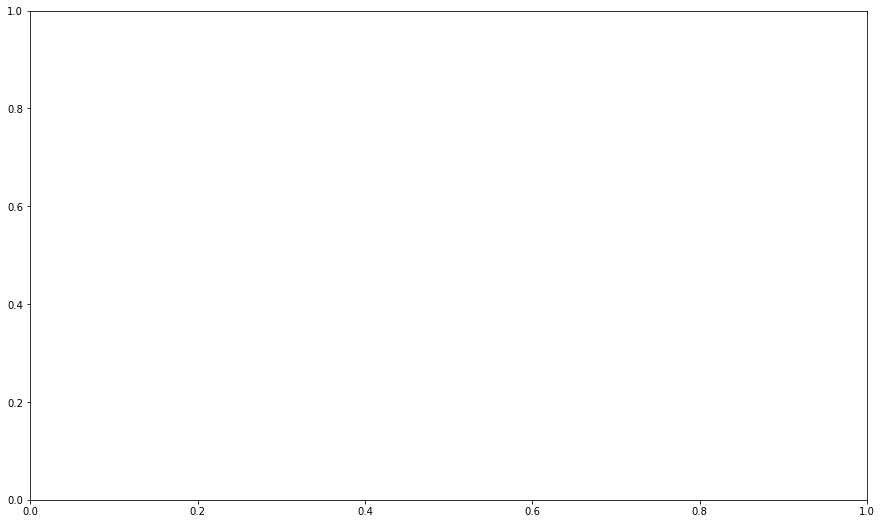

In [135]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15,9))
cmap = plt.cm.seismic

vmin=georgia_data_geo_fil.sentiment_polarity.min()
vmax=georgia_data_geo_fil.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)

G_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black')
# bm.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black')
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)


# df_clu[df_clu['clu']==1].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
df_clu.plot(column='sentiment_polarity', marker='*', markersize=1,cmap=cmap,ax=ax)
df_clu[df_clu['clu']==0].plot(column='sentiment_polarity', marker='^', markersize=20,edgecolor='black',ax=ax)
df_clu[df_clu['clu']==2].plot( column='sentiment_polarity',marker='^', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==8].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==12].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==13].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==23].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
# df_clu[df_clu['clu']==14].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
# ax.set_xlim([395000,422000])
# ax.set_xlim([400000,405000])
# ax.set_ylim([283000,287000])
cbar = f.colorbar(sm)



In [324]:
df_clu.groupby('clu').count()

,sentiment_polarity,sentiment_subjectivity,geometry,lon,lat
clu,,,,,
-1,261,261,261,261,261
0,118,118,118,118,118
1,31,31,31,31,31
2,98,98,98,98,98
3,22,22,22,22,22
4,14,14,14,14,14
5,19,19,19,19,19
6,8,8,8,8,8
7,46,46,46,46,46
